In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import copy

print("Libraries imported successfully.")

Libraries imported successfully.


In [ ]:
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
print(f"Random seed set to {SEED}.")

Random seed set to 42.


In [ ]:
iris = load_iris()
X = iris.data
y = iris.target

print(f"Data loaded. Features shape: {X.shape}, Labels shape: {y.shape}")
print(f"Class names: {iris.target_names}")
print(f"Number of samples per class: {np.bincount(y)}")

Data loaded. Features shape: (150, 4), Labels shape: (150,)
Class names: ['setosa' 'versicolor' 'virginica']
Number of samples per class: [50 50 50]


In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Features scaled using StandardScaler.")
print(f"Original mean (first 5 features): {X[:5].mean(axis=0)}")
print(f"Scaled mean (first 5 features): {X_scaled[:5].mean(axis=0)}")

Features scaled using StandardScaler.
Original mean (first 5 features): [4.86 3.28 1.4  0.2 ]
Scaled mean (first 5 features): [-1.19148406  0.51257147 -1.34022653 -1.3154443 ]


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=SEED, stratify=y
)

print(f"Data split complete.")
print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")
print(f"Training labels distribution: {np.bincount(y_train)}")
print(f"Testing labels distribution: {np.bincount(y_test)}")


Data split complete.
Training samples: 120
Testing samples: 30
Training labels distribution: [40 40 40]
Testing labels distribution: [10 10 10]


In [ ]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

print("Data converted to PyTorch tensors.")
print(f"X_train_tensor shape: {X_train_tensor.shape}, dtype: {X_train_tensor.dtype}")
print(f"y_train_tensor shape: {y_train_tensor.shape}, dtype: {y_train_tensor.dtype}")

Data converted to PyTorch tensors.
X_train_tensor shape: torch.Size([120, 4]), dtype: torch.float32
y_train_tensor shape: torch.Size([120]), dtype: torch.int64


In [ ]:
BATCH_SIZE = 32

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"DataLoaders created with batch size {BATCH_SIZE}.")
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of testing batches: {len(test_loader)}")

DataLoaders created with batch size 32.
Number of training batches: 4
Number of testing batches: 1


In [ ]:
class IrisNet(nn.Module):
    def __init__(self):
        super(IrisNet, self).__init__()
        self.fc1 = nn.Linear(4, 16)  # 4 input features
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(16, 8)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(8, 3)   # 3 output classes

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        # No softmax here, as nn.CrossEntropyLoss applies it internally
        return x

model = IrisNet()
print("Model architecture:")
print(model)

Model architecture:
IrisNet(
  (fc1): Linear(in_features=4, out_features=16, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=16, out_features=8, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=8, out_features=3, bias=True)
)


In [ ]:
# Learning rate
LR = 0.001

# Model
model = IrisNet()

# Loss function
# nn.CrossEntropyLoss is suitable for multi-class classification
criterion = nn.CrossEntropyLoss()

# Optimizer
# Adam is a popular and effective optimizer
optimizer = optim.Adam(model.parameters(), lr=LR)

print("Model, Loss Function (CrossEntropyLoss), and Optimizer (Adam) initialized.")
print(f"Learning Rate: {LR}")

Model, Loss Function (CrossEntropyLoss), and Optimizer (Adam) initialized.
Learning Rate: 0.001


In [ ]:
EPOCHS = 100
train_losses = []
test_losses = []
best_test_loss = float('inf')
best_model_weights = None

print(f"Starting training for {EPOCHS} epochs...")

for epoch in range(EPOCHS):
    # --- Training ---
    model.train()  # Set model to training mode
    running_train_loss = 0.0
    for inputs, labels in train_loader:
        # 1. Zero the gradients
        optimizer.zero_grad()

        # 2. Forward pass
        outputs = model(inputs)

        # 3. Calculate loss
        loss = criterion(outputs, labels)

        # 4. Backward pass
        loss.backward()

        # 5. Update weights
        optimizer.step()

        running_train_loss += loss.item() * inputs.size(0)

    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    # --- Validation ---
    model.eval()  # Set model to evaluation mode
    running_test_loss = 0.0
    with torch.no_grad():  # Disable gradient calculation
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_test_loss += loss.item() * inputs.size(0)

    epoch_test_loss = running_test_loss / len(test_loader.dataset)
    test_losses.append(epoch_test_loss)

    # Save the best model
    if epoch_test_loss < best_test_loss:
        best_test_loss = epoch_test_loss
        best_model_weights = copy.deepcopy(model.state_dict())

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {epoch_train_loss:.4f} | Test Loss: {epoch_test_loss:.4f}")

print("Training finished.")

# Load the best model weights
model.load_state_dict(best_model_weights)
print("Best model weights loaded.")


Starting training for 100 epochs...
Epoch 10/100 | Train Loss: 1.0621 | Test Loss: 1.0570
Epoch 20/100 | Train Loss: 0.9540 | Test Loss: 0.9503
Epoch 30/100 | Train Loss: 0.7682 | Test Loss: 0.7641
Epoch 40/100 | Train Loss: 0.5716 | Test Loss: 0.5744
Epoch 50/100 | Train Loss: 0.4463 | Test Loss: 0.4619
Epoch 60/100 | Train Loss: 0.3729 | Test Loss: 0.3980
Epoch 70/100 | Train Loss: 0.3199 | Test Loss: 0.3525
Epoch 80/100 | Train Loss: 0.2774 | Test Loss: 0.3154
Epoch 90/100 | Train Loss: 0.2411 | Test Loss: 0.2829
Epoch 100/100 | Train Loss: 0.2095 | Test Loss: 0.2531
Training finished.
Best model weights loaded.


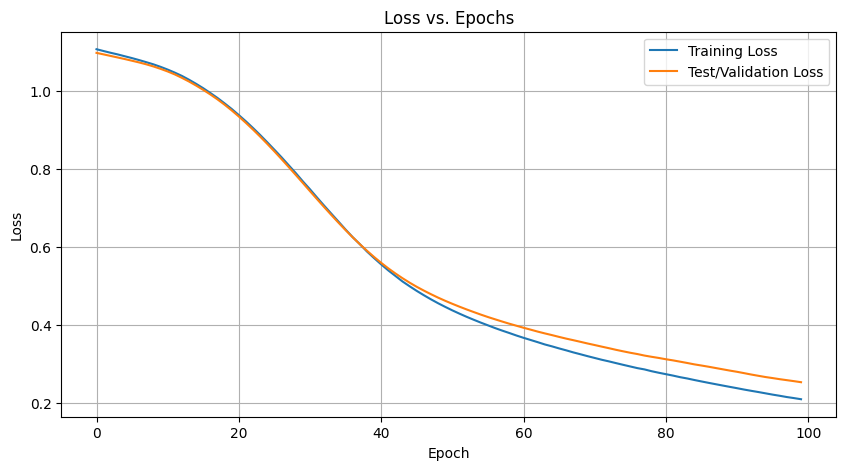

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test/Validation Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
model.eval()  # Set model to evaluation mode
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        # Get the class with the highest score
        _, predicted = torch.max(outputs.data, 1)

        all_preds.extend(predicted.numpy())
        all_labels.extend(labels.numpy())

# Calculate accuracy
accuracy = accuracy_score(all_labels, all_preds)

print(f"\nFinal Model Evaluation:")
print(f"Accuracy on Test Set: {accuracy * 100:.2f}%")


Final Model Evaluation:
Accuracy on Test Set: 90.00%


In [ ]:
MODEL_PATH = 'iris_model.pth'
torch.save(model.state_dict(), MODEL_PATH)

print(f"\nModel state dictionary saved to {MODEL_PATH}")


Model state dictionary saved to iris_model.pth
